<a href="https://colab.research.google.com/github/andrearakel/Mastersverkefni/blob/main/myFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
from pathlib import Path



In [ ]:
%cd '/content/drive/MyDrive/Data/Small data/'

IMG_DIR = 'PNG myndir/'

/content/drive/MyDrive/Data/Small data


In [ ]:
#!python xml_to_csv.py --xml_path='PNG myndir' --csv_output=annotations.csv

Config

In [ ]:
import torch

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 1024 # resize the image for training and transforms
NUM_EPOCHS = 100 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory
TRAIN_DIR = IMG_DIR
VAL_DIR = IMG_DIR
# classes: 0 index is reserved for background
CLASSES = [
    '__background__', 'worm'
]
NUM_CLASSES = len(CLASSES)
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False
# location to save model and plots
OUT_DIR = 'outputs_135'


Utils

In [ ]:
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 4.2 MB/s 
     |████████████████████████████████| 948 kB 27.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=2a20036769fc30a22e7d0c9ebe07fa2d485cce3dd398115cc4dceaf75b219d83
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs_356/best_model.pth')

In [ ]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

#No box transform
def no_box_transform():
  return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
  ])


# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [ ]:
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box_num, box in enumerate(boxes):
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
                cv2.putText(sample, CLASSES[labels[box_num]], 
                            (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 
                            1.0, (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [ ]:
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs_356/last_model.pth')
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

Dataset

In [ ]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader


In [ ]:
import pandas as pd

df = pd.DataFrame(columns=['filename'])
df.set_index('filename')
file_paths = glob.glob(f"{IMG_DIR}/*_01.png")
df['filename'] = file_paths
df.sample(3)
print(len(df))

270


In [ ]:
from sklearn.model_selection import train_test_split
train_set, val_set_base = train_test_split(df, test_size=0.25, random_state=42)

val_set, test_set = train_test_split(val_set_base, test_size=0.1/(0.1+0.15), random_state=42)

In [ ]:
print(val_set)

                                              filename
25    PNG myndir/28_2021-10-04_12.13.48.000_out_01.png
127  PNG myndir/140_2021-10-04_13.13.56.000_out_01.png
146  PNG myndir/158_2021-10-04_13.34.43.000_out_01.png
252  PNG myndir/103_2021-10-04_12.49.17.000_out_01.png
158                     PNG myndir/17_I0017_out_01.png
77    PNG myndir/75_2021-10-04_12.37.30.000_out_01.png
209  PNG myndir/215_2021-10-04_14.08.45.000_out_01.png
184  PNG myndir/193_2021-10-04_13.59.54.000_out_01.png
253  PNG myndir/104_2021-10-04_12.50.15.000_out_01.png
194  PNG myndir/201_2021-10-04_14.03.14.000_out_01.png
199  PNG myndir/206_2021-10-04_14.05.01.000_out_01.png
22    PNG myndir/27_2021-10-04_12.13.20.000_out_01.png
185  PNG myndir/194_2021-10-04_14.00.20.000_out_01.png
225   PNG myndir/23_2021-10-04_12.10.03.000_out_01.png
268  PNG myndir/118_2021-10-04_13.00.15.000_out_01.png
144  PNG myndir/156_2021-10-04_13.33.52.000_out_01.png
233  PNG myndir/237_2021-10-04_14.18.23.000_out_01.png
15   PNG m

In [ ]:
  # the dataset class
class NematodeDataset(Dataset):
    def __init__(self, dir_path, split, width, height, classes, transforms=None, noboxtransform=None):
        self.transforms = transforms
        self.notransforms = noboxtransform
        self.dir_path = dir_path
        self.split = split
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order
        self.image_paths = split['filename']
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image1 = cv2.imread(image_path[:-5] + '1.png')
        image2 = cv2.imread(image_path[:-5] + '3.png')
        image3 = cv2.imread(image_path[:-5] + '5.png')
        image = cv2.merge([image1[:,:,1], image2[:,:,1], image3[:,:,1]])

        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        
        
        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)
       
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
          

        target = {}

        if (len(boxes) == 0):
          boxes = torch.zeros((0,4), dtype=torch.float32)
          target['boxes'] = boxes
          labels = torch.zeros(([0]), dtype=torch.int64)
          target['labels'] = labels    
          target['image_id'] = torch.tensor([idx])
          target["area"] = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
          target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)

          if self.notransforms:
            sample = self.notransforms(image = image_resized)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(boxes)

        else:
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          target['boxes'] = boxes
          target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
          target["image_id"] = torch.tensor([idx])
          target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
          target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

          if self.transforms:
            sample = self.transforms(image = image_resized,
                                      bboxes = target['boxes'], 
                                      labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

            
        return image_resized, target
    def __len__(self):
        return len(self.all_images)

(512, 512, 3)


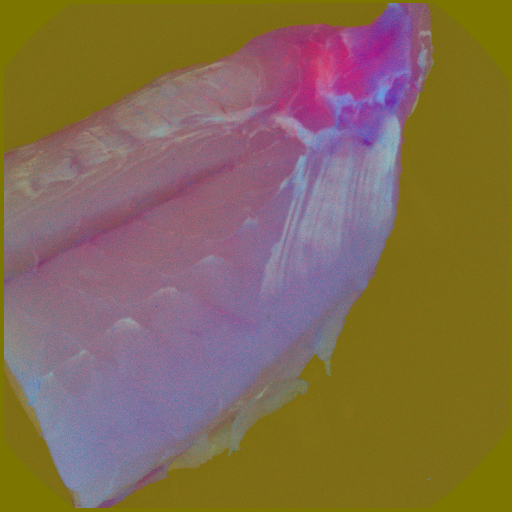

In [ ]:
from google.colab.patches import cv2_imshow
image_test = cv2.imread(IMG_DIR + '1_I0001_out_01.png')
image_test2 = cv2.imread(IMG_DIR + '1_I0001_out_03.png')
image_test3 = cv2.imread(IMG_DIR + '1_I0001_out_05.png')
image = cv2.merge([image_test[:,:,1], image_test2[:,:,1], image_test3[:,:,1]])
image = cv2.resize(image, (512,512))
print(image.shape)
cv2_imshow(image)


In [ ]:
# prepare the final datasets and data loaders
train_dataset = NematodeDataset(IMG_DIR, train_set, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform(),no_box_transform())
valid_dataset = NematodeDataset(IMG_DIR, val_set, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform(), no_box_transform())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

print(train_dataset)

Number of training samples: 202
Number of validation samples: 40



Bounding box visualization

Number of training images: 202


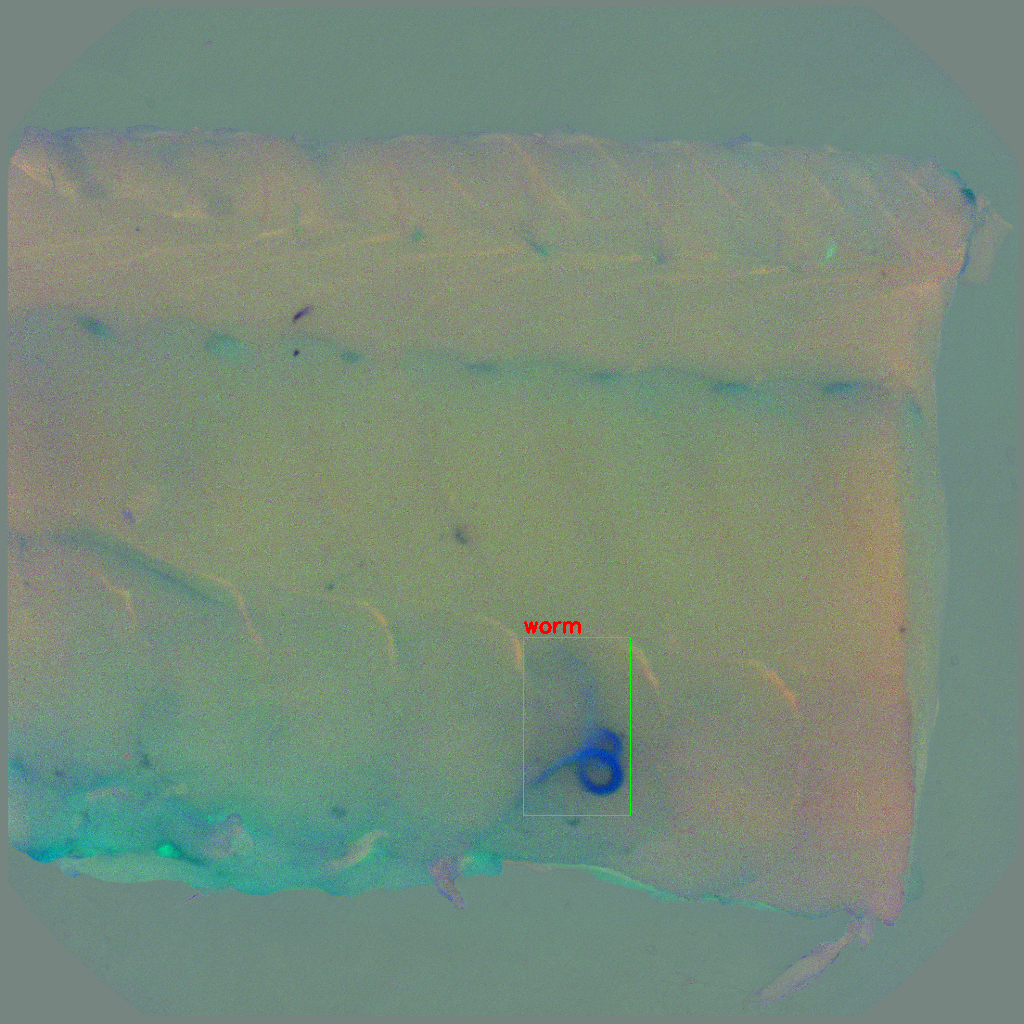

In [ ]:
from google.colab.patches import cv2_imshow

dataset = NematodeDataset(
        IMG_DIR, train_set, RESIZE_TO, RESIZE_TO, CLASSES
    )

print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
    box = target['boxes'][0]
    if (box != []): 
      cv2.rectangle(
          image, 
          (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
          (0, 255, 0), 1
      )
    else:
      print("No bounding box")

    label = CLASSES[target['labels']]
    if (label == []):
      print("No bounding box")
    else:
      cv2.putText(
          image, label, (int(box[0]), int(box[1]-5)), 
          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
      )

    cv2_imshow(image)
    

image, target = dataset[7]
#image = np.array(image)
image = image*255
visualize_sample(image, target)


Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    #num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# For Training
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training

In [ ]:
from tqdm.auto import tqdm
import time


# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

Validation

In [ ]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [ ]:
# initialize the model and move to the computation device
model = get_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'

# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
  show_tranformed_image(train_loader)


# initialize SaveBestModel class
save_best_model = SaveBestModel()
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    # save the best model till now if we have the least loss in the...
    # ... current epoch
    save_best_model(
        val_loss_hist.value, epoch, model, optimizer
    )
    # save the current epoch model
    save_model(epoch, model, optimizer)
    # save loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss)
    
    # sleep for 5 seconds after each epoch
    time.sleep(5)


EPOCH 1 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1 train loss: 0.205
Epoch #1 validation loss: 0.234
Took 2.894 minutes for epoch 0

Best validation loss: 0.23418260216712952

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2 train loss: 0.166
Epoch #2 validation loss: 0.219
Took 2.763 minutes for epoch 1

Best validation loss: 0.21897141821682453

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #3 train loss: 0.158
Epoch #3 validation loss: 0.212
Took 2.730 minutes for epoch 2

Best validation loss: 0.21165239699184896

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #4 train loss: 0.145
Epoch #4 validation loss: 0.200
Took 2.728 minutes for epoch 3

Best validation loss: 0.1997042890638113

Saving best model for epoch: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5 train loss: 0.139
Epoch #5 validation loss: 0.188
Took 2.731 minutes for epoch 4

Best validation loss: 0.1881808340549469

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6 train loss: 0.130
Epoch #6 validation loss: 0.175
Took 2.714 minutes for epoch 5

Best validation loss: 0.1748092021793127

Saving best model for epoch: 6

SAVING PLOTS COMPLETE...

EPOCH 7 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7 train loss: 0.118
Epoch #7 validation loss: 0.176
Took 2.704 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8 train loss: 0.116
Epoch #8 validation loss: 0.167
Took 2.714 minutes for epoch 7

Best validation loss: 0.16729026325047017

Saving best model for epoch: 8

SAVING PLOTS COMPLETE...

EPOCH 9 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9 train loss: 0.113
Epoch #9 validation loss: 0.157
Took 2.736 minutes for epoch 8

Best validation loss: 0.15681872945278882

Saving best model for epoch: 9

SAVING PLOTS COMPLETE...

EPOCH 10 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10 train loss: 0.114
Epoch #10 validation loss: 0.166
Took 2.728 minutes for epoch 9
SAVING PLOTS COMPLETE...

EPOCH 11 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11 train loss: 0.107
Epoch #11 validation loss: 0.143
Took 2.690 minutes for epoch 10

Best validation loss: 0.14313838724046946

Saving best model for epoch: 11

SAVING PLOTS COMPLETE...

EPOCH 12 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12 train loss: 0.114
Epoch #12 validation loss: 0.161
Took 2.722 minutes for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 13 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13 train loss: 0.105
Epoch #13 validation loss: 0.154
Took 2.705 minutes for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 14 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #14 train loss: 0.103
Epoch #14 validation loss: 0.168
Took 2.712 minutes for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 15 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #15 train loss: 0.104
Epoch #15 validation loss: 0.154
Took 2.691 minutes for epoch 14
SAVING PLOTS COMPLETE...

EPOCH 16 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16 train loss: 0.101
Epoch #16 validation loss: 0.160
Took 2.676 minutes for epoch 15
SAVING PLOTS COMPLETE...

EPOCH 17 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17 train loss: 0.099
Epoch #17 validation loss: 0.157
Took 2.672 minutes for epoch 16
SAVING PLOTS COMPLETE...

EPOCH 18 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18 train loss: 0.106
Epoch #18 validation loss: 0.163
Took 2.658 minutes for epoch 17
SAVING PLOTS COMPLETE...

EPOCH 19 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19 train loss: 0.103
Epoch #19 validation loss: 0.169
Took 2.667 minutes for epoch 18
SAVING PLOTS COMPLETE...

EPOCH 20 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20 train loss: 0.098
Epoch #20 validation loss: 0.152
Took 2.669 minutes for epoch 19
SAVING PLOTS COMPLETE...

EPOCH 21 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #21 train loss: 0.100
Epoch #21 validation loss: 0.149
Took 2.635 minutes for epoch 20
SAVING PLOTS COMPLETE...

EPOCH 22 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #22 train loss: 0.096
Epoch #22 validation loss: 0.157
Took 2.622 minutes for epoch 21
SAVING PLOTS COMPLETE...

EPOCH 23 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #23 train loss: 0.093
Epoch #23 validation loss: 0.176
Took 2.618 minutes for epoch 22
SAVING PLOTS COMPLETE...

EPOCH 24 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #24 train loss: 0.094
Epoch #24 validation loss: 0.157
Took 2.609 minutes for epoch 23
SAVING PLOTS COMPLETE...

EPOCH 25 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #25 train loss: 0.093
Epoch #25 validation loss: 0.172
Took 2.613 minutes for epoch 24
SAVING PLOTS COMPLETE...

EPOCH 26 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #26 train loss: 0.086
Epoch #26 validation loss: 0.178
Took 2.634 minutes for epoch 25
SAVING PLOTS COMPLETE...

EPOCH 27 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #27 train loss: 0.087
Epoch #27 validation loss: 0.169
Took 2.640 minutes for epoch 26
SAVING PLOTS COMPLETE...

EPOCH 28 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #28 train loss: 0.086
Epoch #28 validation loss: 0.168
Took 2.637 minutes for epoch 27
SAVING PLOTS COMPLETE...

EPOCH 29 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #29 train loss: 0.087
Epoch #29 validation loss: 0.172
Took 2.665 minutes for epoch 28
SAVING PLOTS COMPLETE...

EPOCH 30 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #30 train loss: 0.087
Epoch #30 validation loss: 0.166
Took 2.658 minutes for epoch 29
SAVING PLOTS COMPLETE...

EPOCH 31 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #31 train loss: 0.086
Epoch #31 validation loss: 0.169
Took 2.635 minutes for epoch 30
SAVING PLOTS COMPLETE...

EPOCH 32 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #32 train loss: 0.089
Epoch #32 validation loss: 0.189
Took 2.637 minutes for epoch 31
SAVING PLOTS COMPLETE...

EPOCH 33 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #33 train loss: 0.086
Epoch #33 validation loss: 0.165
Took 2.653 minutes for epoch 32
SAVING PLOTS COMPLETE...

EPOCH 34 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #34 train loss: 0.084
Epoch #34 validation loss: 0.176
Took 2.643 minutes for epoch 33
SAVING PLOTS COMPLETE...

EPOCH 35 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #35 train loss: 0.085
Epoch #35 validation loss: 0.187
Took 2.635 minutes for epoch 34
SAVING PLOTS COMPLETE...

EPOCH 36 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #36 train loss: 0.082
Epoch #36 validation loss: 0.189
Took 2.631 minutes for epoch 35
SAVING PLOTS COMPLETE...

EPOCH 37 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #37 train loss: 0.079
Epoch #37 validation loss: 0.185
Took 2.642 minutes for epoch 36
SAVING PLOTS COMPLETE...

EPOCH 38 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #38 train loss: 0.080
Epoch #38 validation loss: 0.186
Took 2.664 minutes for epoch 37
SAVING PLOTS COMPLETE...

EPOCH 39 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #39 train loss: 0.077
Epoch #39 validation loss: 0.173
Took 2.651 minutes for epoch 38
SAVING PLOTS COMPLETE...

EPOCH 40 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #40 train loss: 0.080
Epoch #40 validation loss: 0.201
Took 2.670 minutes for epoch 39
SAVING PLOTS COMPLETE...

EPOCH 41 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #41 train loss: 0.080
Epoch #41 validation loss: 0.195
Took 2.682 minutes for epoch 40
SAVING PLOTS COMPLETE...

EPOCH 42 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #42 train loss: 0.073
Epoch #42 validation loss: 0.195
Took 2.677 minutes for epoch 41
SAVING PLOTS COMPLETE...

EPOCH 43 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #43 train loss: 0.073
Epoch #43 validation loss: 0.184
Took 2.671 minutes for epoch 42
SAVING PLOTS COMPLETE...

EPOCH 44 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #44 train loss: 0.076
Epoch #44 validation loss: 0.175
Took 2.657 minutes for epoch 43
SAVING PLOTS COMPLETE...

EPOCH 45 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #45 train loss: 0.071
Epoch #45 validation loss: 0.197
Took 2.675 minutes for epoch 44
SAVING PLOTS COMPLETE...

EPOCH 46 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #46 train loss: 0.073
Epoch #46 validation loss: 0.202
Took 2.680 minutes for epoch 45
SAVING PLOTS COMPLETE...

EPOCH 47 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #47 train loss: 0.076
Epoch #47 validation loss: 0.179
Took 2.709 minutes for epoch 46
SAVING PLOTS COMPLETE...

EPOCH 48 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #48 train loss: 0.070
Epoch #48 validation loss: 0.204
Took 2.707 minutes for epoch 47
SAVING PLOTS COMPLETE...

EPOCH 49 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #49 train loss: 0.072
Epoch #49 validation loss: 0.224
Took 2.686 minutes for epoch 48
SAVING PLOTS COMPLETE...

EPOCH 50 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #50 train loss: 0.073
Epoch #50 validation loss: 0.199
Took 2.674 minutes for epoch 49
SAVING PLOTS COMPLETE...

EPOCH 51 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #51 train loss: 0.081
Epoch #51 validation loss: 0.194
Took 2.710 minutes for epoch 50
SAVING PLOTS COMPLETE...

EPOCH 52 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #52 train loss: 0.073
Epoch #52 validation loss: 0.181
Took 2.689 minutes for epoch 51
SAVING PLOTS COMPLETE...

EPOCH 53 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #53 train loss: 0.068
Epoch #53 validation loss: 0.217
Took 2.682 minutes for epoch 52
SAVING PLOTS COMPLETE...

EPOCH 54 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #54 train loss: 0.067
Epoch #54 validation loss: 0.207
Took 2.684 minutes for epoch 53
SAVING PLOTS COMPLETE...

EPOCH 55 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #55 train loss: 0.067
Epoch #55 validation loss: 0.200
Took 2.685 minutes for epoch 54
SAVING PLOTS COMPLETE...

EPOCH 56 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #56 train loss: 0.070
Epoch #56 validation loss: 0.206
Took 2.692 minutes for epoch 55
SAVING PLOTS COMPLETE...

EPOCH 57 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #57 train loss: 0.070
Epoch #57 validation loss: 0.203
Took 2.687 minutes for epoch 56
SAVING PLOTS COMPLETE...

EPOCH 58 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #58 train loss: 0.067
Epoch #58 validation loss: 0.205
Took 2.698 minutes for epoch 57
SAVING PLOTS COMPLETE...

EPOCH 59 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #59 train loss: 0.067
Epoch #59 validation loss: 0.217
Took 2.723 minutes for epoch 58
SAVING PLOTS COMPLETE...

EPOCH 60 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #60 train loss: 0.065
Epoch #60 validation loss: 0.214
Took 2.718 minutes for epoch 59
SAVING PLOTS COMPLETE...

EPOCH 61 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #61 train loss: 0.064
Epoch #61 validation loss: 0.215
Took 2.698 minutes for epoch 60
SAVING PLOTS COMPLETE...

EPOCH 62 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #62 train loss: 0.063
Epoch #62 validation loss: 0.238
Took 2.699 minutes for epoch 61
SAVING PLOTS COMPLETE...

EPOCH 63 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #63 train loss: 0.062
Epoch #63 validation loss: 0.236
Took 2.684 minutes for epoch 62
SAVING PLOTS COMPLETE...

EPOCH 64 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #64 train loss: 0.062
Epoch #64 validation loss: 0.232
Took 2.700 minutes for epoch 63
SAVING PLOTS COMPLETE...

EPOCH 65 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #65 train loss: 0.063
Epoch #65 validation loss: 0.235
Took 2.684 minutes for epoch 64
SAVING PLOTS COMPLETE...

EPOCH 66 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #66 train loss: 0.060
Epoch #66 validation loss: 0.235
Took 2.681 minutes for epoch 65
SAVING PLOTS COMPLETE...

EPOCH 67 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #67 train loss: 0.062
Epoch #67 validation loss: 0.228
Took 2.680 minutes for epoch 66
SAVING PLOTS COMPLETE...

EPOCH 68 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #68 train loss: 0.064
Epoch #68 validation loss: 0.244
Took 2.676 minutes for epoch 67
SAVING PLOTS COMPLETE...

EPOCH 69 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

Validating


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #69 train loss: 0.059
Epoch #69 validation loss: 0.212
Took 2.667 minutes for epoch 68
SAVING PLOTS COMPLETE...

EPOCH 70 of 100
Training


  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Inference

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time



# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [ ]:
# load the best model and trained weights
model = get_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs_135/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.5
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0 

In [ ]:
image_paths = test_set['filename']
all_images = [image_path.split('/')[-1] for image_path in image_paths]
all_images = sorted(all_images)


for i in range(len(all_images)):
    # get the image file name for saving output later on 
    image_name = all_images[i]
    print(image_name)
    # capture the image name and the full image path
    image_path = os.path.join(IMG_DIR, image_name)
    # read the image
    image1 = cv2.imread(image_path[:-5] + '1.png')
    image2 = cv2.imread(image_path[:-5] + '3.png')
    image3 = cv2.imread(image_path[:-5] + '5.png')
    image = cv2.merge([image1[:,:,1], image2[:,:,1], image3[:,:,1]])
 
    orig_img = image.copy()

    image = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)
 
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(DEVICE))
    end_time = time.time()
    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    # print(outputs[0]['scores'] + " " + outputs[0]['boxes'])
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        #orig_img = orig_img * 255
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            cv2.rectangle(orig_img,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 255, 0), 1)
            cv2.putText(orig_img, class_name + " " + str(scores[j]), 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 3, color, 
                        1, lineType=cv2.LINE_AA)
            print(class_name + " " + str(scores[j]) + " " + str(int(box[0])) + " " + str(int(box[1])) + " " + str(int(box[2])) + " " + str(int(box[3])))
        #cv2_imshow(orig_img)
        cv2.imwrite(f"{OUT_DIR}/{image_name}.jpg", orig_img)

   
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

124_2021-10-04_13.02.43.000_out_01.png
worm 0.9698099 1884 668 2185 1028
worm 0.9689596 590 2037 883 2453
worm 0.94323856 617 1978 802 2135
worm 0.8129446 555 2202 694 2400
Image 1 done...
--------------------------------------------------
128_2021-10-04_13.04.53.000_out_01.png
worm 0.90197223 2050 1188 2222 1971
worm 0.78135896 1742 2854 2021 2985
worm 0.75365347 1810 2857 1938 2982
worm 0.66243774 1817 2890 1895 2983
worm 0.50259197 1795 2900 2045 2981
Image 2 done...
--------------------------------------------------
134_2021-10-04_13.07.41.000_out_01.png
Image 3 done...
--------------------------------------------------
139_2021-10-04_13.13.25.000_out_01.png
Image 4 done...
--------------------------------------------------
13_I0013_out_01.png
worm 0.9195052 1802 1828 1906 1938
worm 0.8906207 357 1639 415 1737
worm 0.87919253 1065 1645 1635 1944
worm 0.81764215 1740 1110 2050 1357
worm 0.6258694 357 1626 417 1837
worm 0.6121247 1380 555 1517 687
worm 0.531882 1696 2205 1895 2316
Im

Another implementation of training and validation

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 1

# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10
from engine import train_one_epoch, evaluate

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dataloader, device=device)

Epoch: [0]  [ 0/48]  eta: 0:02:12  lr: 0.000111  loss: 0.5910 (0.5910)  loss_classifier: 0.5508 (0.5508)  loss_box_reg: 0.0007 (0.0007)  loss_objectness: 0.0375 (0.0375)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 2.7690  data: 2.2968  max mem: 3310
Epoch: [0]  [10/48]  eta: 0:01:45  lr: 0.001174  loss: 0.3803 (0.3856)  loss_classifier: 0.2139 (0.2613)  loss_box_reg: 0.0112 (0.0184)  loss_objectness: 0.0927 (0.1009)  loss_rpn_box_reg: 0.0044 (0.0051)  time: 2.7654  data: 2.3160  max mem: 3315
Epoch: [0]  [20/48]  eta: 0:01:17  lr: 0.002237  loss: 0.2727 (0.3157)  loss_classifier: 0.0870 (0.1792)  loss_box_reg: 0.0160 (0.0282)  loss_objectness: 0.0927 (0.0997)  loss_rpn_box_reg: 0.0066 (0.0086)  time: 2.7796  data: 2.3330  max mem: 3315
Epoch: [0]  [30/48]  eta: 0:00:50  lr: 0.003300  loss: 0.2071 (0.2775)  loss_classifier: 0.0870 (0.1553)  loss_box_reg: 0.0470 (0.0368)  loss_objectness: 0.0541 (0.0779)  loss_rpn_box_reg: 0.0048 (0.0074)  time: 2.7854  data: 2.3401  max mem: 3315
Epoch: [

Validation


In [ ]:
img, _ = val_dataset[6]
print(img, _)
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

tensor([[[0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
         [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
         [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
         ...,
         [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
         [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922],
         [0.5922, 0.5922, 0.5922,  ..., 0.5922, 0.5922, 0.5922]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745],
         [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745],
         [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745],
         ...,
         [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745],
         [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745],
         [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4745]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]